In [29]:
## PATH settings
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.append(project_root)
COMMON_PATH = os.path.join(project_root, 'common')

In [30]:
## Bespoke class imports
from common.database.adatabase import ADatabase
from common.processor.processor import Processor as p
from financial_common.risk.rolling_factor_analysis import RollingFactorAnalysis
from financial_common.risk.single_index_capm import SingleIndexCAPM
from financial_common.indicator.indicator import Indicator
from financial_common.risk.benchmark import Benchmark
from financial_common.portfolio_management.metrics import Metrics
from financial_common.portfolio_management.portfolio_selection import PortfolioSelection
from financial_common.risk.risk_type import RiskType
import numpy as np

In [31]:
## Import standard packages
from datetime import timedelta
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from time import sleep
import copy

In [32]:
market = ADatabase("market")
fred = ADatabase("fred")

In [33]:
## Retrieve existing stocks 
market.connect()
index = market.retrieve("ticker_overview")
market.disconnect()
sic_codes = pd.read_csv("../../csv_files/sic_codes.csv").rename(columns={"SIC Code":"sic_code","Office":"office"}).dropna()
index["sic_code"] = index["sic_code"].fillna(0).astype(int)
sic_codes["sic_code"] = sic_codes["sic_code"].fillna(0).astype(int)
index = index.merge(sic_codes[["sic_code","office"]],on="sic_code")

In [34]:
market.connect()
prices = []
for ticker in tqdm(index["ticker"]): 
    try:
        price = market.query("prices", {"ticker": ticker})
        if price.index.size > 150:
            price = p.lower_column(price)
            price = p.utc_date(price)
        
            price.sort_values("date", inplace=True)
            price = p.additional_date_columns(price)
            for member in Indicator:
                price = member.calculate(price)
            for member in RiskType:
                price = member.apply(price)
            prices.append(price)
    except Exception as e:
        print(str(e))
        continue
market.disconnect()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4327/4327 [03:16<00:00, 22.06it/s]


In [35]:
model_end = 2013
backtest_end = 2026
simulation = pd.concat(prices).merge(index[["ticker","name","market_cap","office","sic_description"]],on="ticker",how="left")
simulation["market_cap"] = simulation["market_cap"].astype(float)
## subsetting backtesting data
simulation = simulation[(simulation["year"]>=model_end) & (simulation["year"]<backtest_end)]
tickers = list(simulation[simulation["year"]==model_end]["ticker"].unique())
simulation = simulation[simulation["ticker"].isin(tickers)]

simulation.sort_values("date", inplace=True)
simulation.columns

Index(['date', 'close', 'high', 'low', 'open', 'volume', 'adjclose', 'adjhigh',
       'adjlow', 'adjopen', 'adjvolume', 'divcash', 'splitfactor', 'ticker',
       'year', 'month', 'quarter', 'week', 'reference_price',
       'reference_volume', 'reference_high', 'reference_low',
       'rolling_dollar_volume', 'adr', 'sma', 'ema', 'bollinger_upper',
       'bollinger_lower', 'momentum', 'roc', 'williams_r', 'obv', 'vwap',
       'market_impact', 'atr', 'coefficient_of_variation', 'drawdown', 'name',
       'market_cap', 'office', 'sic_description'],
      dtype='object')

In [36]:
## Defining Benchmark
market.connect()
benchmark = market.query("prices",{"ticker":"JPM"})
market.disconnect()
benchmark = Benchmark.convert_to_benchmark(benchmark,"adjclose")

In [37]:
portfolios = PortfolioSelection.generate_possible_portfolios(group_percentages=[0.01])

In [38]:
additional_portfolios = []

for portfolio in portfolios:
    for member in Indicator:
        portfolio_copy = copy.deepcopy(portfolio)
        portfolio_copy.ranking_metric = member.label
        additional_portfolios.append(portfolio_copy)


In [39]:
analysises = []
for portfolio in tqdm(additional_portfolios):
    try:
        trades = portfolio.trades(simulation.copy())
        performance = portfolio.portfolio(trades.copy(),benchmark.copy())
        metrics = Metrics.performance(trades,performance)
        results = {**portfolio.to_dict(),**metrics.copy()}
        results["portfolio"] = portfolio
        analysises.append(results)
    except Exception as e:
        print(str(e))
        continue

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2808/2808 [95:57:22<00:00, 123.02s/it]


In [40]:
a = pd.DataFrame(analysises)
a.columns

Index(['timeframe', 'ranking_metric', 'position_type', 'grouping_type',
       'selection_type', 'allocation_type', 'risk_type',
       'selection_percentage', 'date', 'pnl', 'coefficient_of_variation',
       'portfolio_std', 'average_gain', 'average_loss', 'win_loss_ratio',
       'weekly_return', 'sharpe_ratio', 'portfolio'],
      dtype='object')

In [41]:
a.reset_index().drop("date",axis=1).sort_values("pnl",ascending=False).head(20)

,index,timeframe,ranking_metric,position_type,grouping_type,selection_type,allocation_type,risk_type,selection_percentage,pnl,coefficient_of_variation,portfolio_std,average_gain,average_loss,win_loss_ratio,weekly_return,sharpe_ratio,portfolio
1427,1427,month,vwap,short,OFFICE,mixed,equal,coefficient_of_variation,0.01,998.143108,3.941618,253.231842,1.155254,0.900026,0.550725,1.040586,3.914952,<financial_common.portfolio_management.portfol...
1453,1453,month,vwap,short,OFFICE,mixed,equal,drawdown,0.01,998.143108,3.941618,253.231842,1.155254,0.900026,0.550725,1.040586,3.914952,<financial_common.portfolio_management.portfol...
1429,1429,month,atr,short,OFFICE,mixed,equal,coefficient_of_variation,0.01,495.195645,3.902061,126.906185,1.129788,0.906160,0.582609,1.036447,3.848852,<financial_common.portfolio_management.portfol...
1455,1455,month,atr,short,OFFICE,mixed,equal,drawdown,0.01,495.195645,3.902061,126.906185,1.129788,0.906160,0.582609,1.036447,3.848852,<financial_common.portfolio_management.portfol...
2389,2389,week,vwap,short,OFFICE,mixed,equal,drawdown,0.01,451.454125,4.401851,102.560056,1.056814,0.950105,0.560308,1.009895,4.334713,<financial_common.portfolio_management.portfol...
2363,2363,week,vwap,short,OFFICE,mixed,equal,coefficient_of_variation,0.01,451.454125,4.401851,102.560056,1.056814,0.950105,0.560308,1.009895,4.334713,<financial_common.portfolio_management.portfol...
1739,1739,month,vwap,short,OFFICE,bottom,equal,coefficient_of_variation,0.01,335.983890,4.255432,78.954129,1.146945,0.899748,0.568116,1.040184,4.169907,<financial_common.portfolio_management.portfol...
1765,1765,month,vwap,short,OFFICE,bottom,equal,drawdown,0.01,335.983890,4.255432,78.954129,1.146945,0.899748,0.568116,1.040184,4.169907,<financial_common.portfolio_management.portfol...
1418,1418,month,adr,short,OFFICE,mixed,equal,coefficient_of_variation,0.01,222.678442,4.872653,45.699632,1.113919,0.887239,0.621256,1.028066,4.724894,<financial_common.portfolio_management.portfol...
1444,1444,month,adr,short,OFFICE,mixed,equal,drawdown,0.01,222.678442,4.872653,45.699632,1.113919,0.887239,0.621256,1.028066,4.724894,<financial_common.portfolio_management.portfol...


In [42]:
a["color"] = ["blue" if x == "top" else "red" if x == "bottom"  else "green" for x in a["selection_type"]]
a["return_to_risk"] = a["pnl"] / a["portfolio_std"]

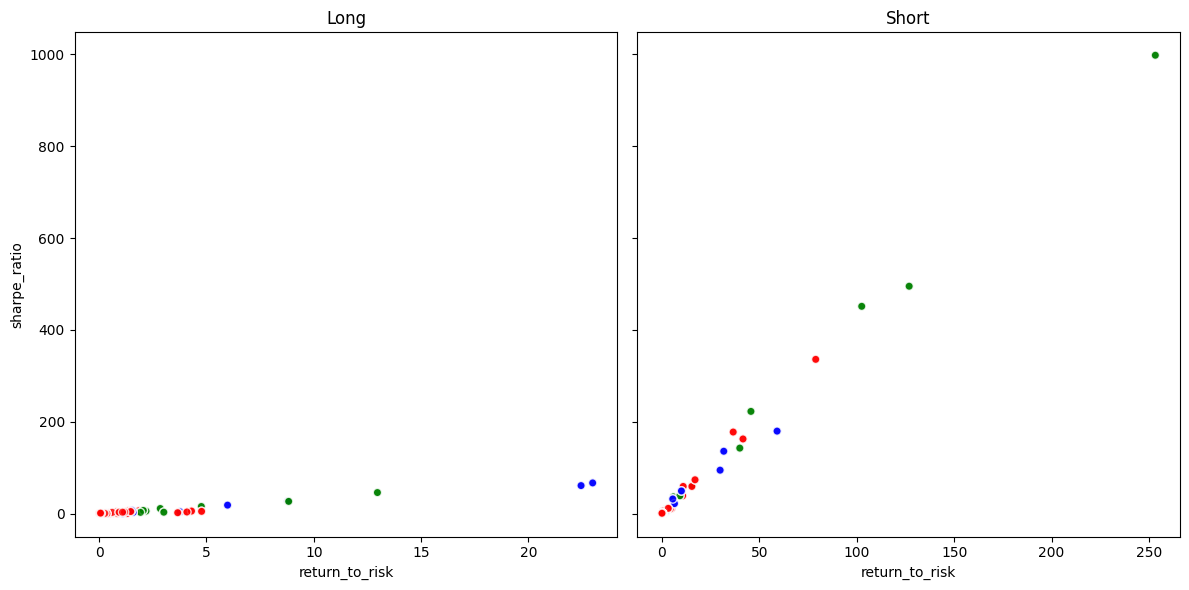

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Titles for each subplot
titles = ["Long", "Short"]

# Iterate over directions and corresponding axes
for i, position_type in enumerate(["long", "short"]):
    d_analysis = a[a["position_type"] == position_type]
    axes[i].scatter(
        d_analysis["portfolio_std"],
        d_analysis["pnl"],
        c=d_analysis["color"],
        alpha=0.8,
        edgecolors="w",
    )
    axes[i].set_title(titles[i])
    axes[i].set_xlabel("return_to_risk")
    axes[i].set_ylabel("sharpe_ratio" if i == 0 else "")  # Only label y-axis on the first plot

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined plot
plt.show()

In [44]:
top = a.sort_values("pnl",ascending=False).head(1).to_dict("records")[0]
top

{'timeframe': 'month',
 'ranking_metric': 'vwap',
 'position_type': 'short',
 'grouping_type': 'OFFICE',
 'selection_type': 'mixed',
 'allocation_type': 'equal',
 'risk_type': 'coefficient_of_variation',
 'selection_percentage': 0.01,
 'date': Timestamp('2025-04-03 00:00:00+0000', tz='UTC'),
 'pnl': 998.1431075055791,
 'coefficient_of_variation': 3.941617688840978,
 'portfolio_std': 253.23184192404017,
 'average_gain': 1.1552540242988438,
 'average_loss': 0.9000256885858547,
 'win_loss_ratio': 0.5507246376811594,
 'weekly_return': 1.040586221297356,
 'sharpe_ratio': 3.9149522823919485,
 'portfolio': <financial_common.portfolio_management.portfolio.Portfolio at 0x194f0229590>,
 'color': 'green',
 'return_to_risk': 3.941617688840978}

In [45]:
pm = top["portfolio"]
trades = pm.trades(simulation.copy()).merge(index[["ticker","name","office"]],on="ticker",how="left")
trades = p.additional_date_columns(trades)
portfolio = pm.portfolio(trades.copy(),benchmark.copy())
portfolio = p.additional_date_columns(portfolio)

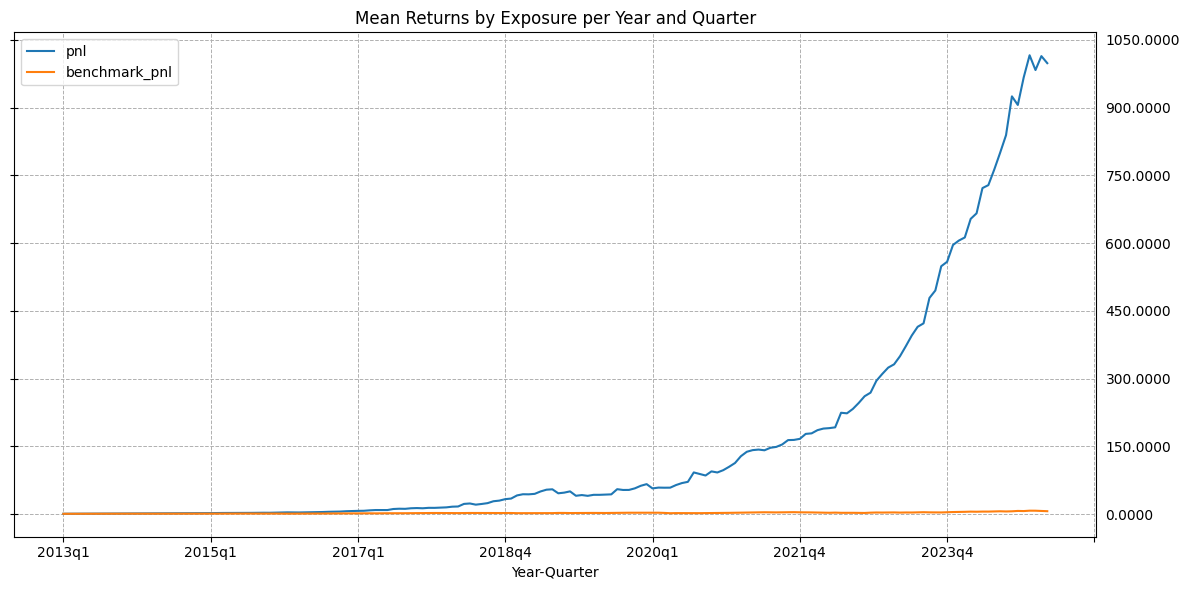

In [46]:
portfolio['Year-Quarter'] = portfolio["year"].astype(str) + "q" + portfolio["quarter"].astype(str)
ax = portfolio[["Year-Quarter","pnl","benchmark_pnl"]].set_index("Year-Quarter").plot(
    kind="line",
    figsize=(12, 6),
    title="Mean Returns by Exposure per Year and Quarter"
)

# Set y-axis to have more precise ticks
ax.tick_params(axis='y', direction='in', length=6)  # Adjust y-tick direction and length
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.4f}'))  # Format y-ticks with 4 decimal places

# Move y-ticks to the right side
ax.yaxis.set_tick_params(which='both', direction='inout', length=6, labelleft=False, labelright=True)

# Optionally adjust the number of ticks for better precision
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=False, prune='both'))

# Add grid lines
ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.7)

# Display the plot
plt.tight_layout()
plt.show()

In [47]:
trades[["office","return"]].groupby("office").mean().sort_values("return",ascending=False)

,return
office,
Industrial Applications and Services,1.086365
Office of Manufacturing,1.080906
Office of Technology,1.056505
Office of Finance or Office of Crypto Assets,1.047183
Office of Real Estate & Construction,1.032985
Office of Trade & Services or Office of Energy & Transportation,1.027629
Office of Life Sciences,1.020854
Office of Crypto Assets,1.014046
Office of Finance,1.013743
